In [ ]:
# Generating random points for an Image

from PINN.pointsGeneration import *
from ImageGenerator import generate_image
import os


size_image = 32
_, image = generate_image(D=size_image)

# nr_samples = 40000
# ratio = 0.5
# inner_samples = int(nr_samples * ratio)
# boundary_samples = nr_samples-

inner_samples = 5000
boundary_samples = 5000

print("Number of inner points: ", inner_samples)
print("Number of boundary points: ", boundary_samples)

lamb=1
mu=0.5
nu = lamb/ (2*lamb + 2*mu)
E = mu * 2*(1+nu)

innerPoints = generateInnerPoints(image, size_image, inner_samples, E, 1, nu)
boundaryPoints = generateBoundaryPoints(image, size_image, boundary_samples, E, 1, nu)

dataSet = innerPoints, boundaryPoints

from PINN.plot import printDataSet2
printDataSet2(dataSet, image)

In [1]:
# Models 
import torch
import torch.nn as nn
import torch.nn.functional as F

class sigmaPINN(nn.Module):
    # x -> sigma

  def __init__(self, layers = [2, 40, 40, 40, 40, 40, 4]):
    super().__init__()
    self.fc_list = nn.ModuleList()
    for i in range(len(layers)-1):
      self.fc_list.append( nn.Linear(layers[i], layers[i+1]))

  def forward(self, x):
    for i in range(len(self.fc_list)-1):
      fc = self.fc_list[i]
      x = fc(x)
      x = F.tanh(x)
    fc = self.fc_list[-1]
    x = fc(x)
    return x

class displacementPINN(nn.Module):
    # x -> u
  
  def __init__(self, layers = [2, 40, 40, 40, 40, 40, 2]):
    super().__init__()
    self.fc_list = nn.ModuleList()
    for i in range(len(layers)-1):
      self.fc_list.append( nn.Linear(layers[i], layers[i+1]))

  def forward(self, x):
    for i in range(len(self.fc_list)-1):
      fc = self.fc_list[i]
      x = fc(x)
      x = F.tanh(x)
    fc = self.fc_list[-1]
    x = fc(x)
    return x

# Xavier Uniform Initialization for all weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)  # Xavier Uniform
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)  # Initialize biases to 0

In [2]:
# Defining the Loss

import torch.autograd as autograd
from PINN.lossFunctions import *

class PDELoss(nn.Module):
    def __init__(self, lossParam = [1, 1, 1, 1], device='cpu'):
        super(PDELoss, self).__init__()
        self.hyperparameter = lossParam
        self.device=device

    def forward(self, innerPoints, boundaryPoints, modelSigma, modelU, f=0, boundaryForce=0, boundaryDisplacement=0, innerLambda=0, innerMu=0, normalVector=0, maskForce=0,
                maskDisplacement=0):
      
      divergent = getDivergentSigma(innerPoints, modelSigma)
      LInner = checkLoss(-divergent, f) # absolute value

      t = getForceEstimationBoundary(boundaryPoints, modelSigma, normalVector=normalVector)
      LBoundary = checkLoss(t, boundaryForce, mask=maskForce)

      sigmafromEpsilon = getSigmafromEpsilon(innerPoints, modelU, lamb=innerLambda, mu=innerMu)
      innerSigma = modelSigma(innerPoints)
      LInnerU = checkLoss(innerSigma, sigmafromEpsilon)
      
      boundaryU = getDisplacementEstimationBoundary(boundaryPoints, modelU)
      LBoundaryU = checkLoss(boundaryU, boundaryDisplacement, mask=maskDisplacement)
     
      boundarySigma = modelSigma(boundaryPoints)
      LSigma = torch.sum((innerSigma[:, 1] - innerSigma[:, 2])**2, dim=0, keepdim=True) + torch.sum((boundarySigma[:, 1] - boundarySigma[:, 2])**2, dim=0, keepdim=True)
      LSigma = LSigma / innerSigma.shape[0]
      
      Loss = LInner + self.hyperparameter[0] * LBoundary + self.hyperparameter[1] * LInnerU + self.hyperparameter[2] * LBoundaryU + self.hyperparameter[3] * LSigma
      return Loss, LInner+LInnerU, LBoundary+LBoundaryU

In [33]:
# Check Loss function
from PINN.analSolution import *
from PINN.Dataloader import *
checkingLoss = PDELoss(lossParam=[1, 1, 1, 1])

device = 'cuda'
lamb=1
mu=0.5
nu = lamb/ (2*lamb + 2*mu)
E = mu * 2*(1+nu)

from PINN.pointsGeneration import *
innerPoints = generateInnerPoints2(image, size_image, inner_samples, E, 1, nu)
boundaryPoints = generateBoundaryPoints(image, size_image, boundary_samples, E, 1, nu)

dataSet = innerPoints, boundaryPoints
preparedDataSet = datapreparation(dataSet)
checkDataLoader = dataloading(preparedDataSet, boundary_samples)

for i, (inner_batch, boundary_batch, lambda_batch, mu_batch, normalVector_batch, maskForce_batch, maskDisplacement_batch,
            f_batch, boundaryForce_batch, boundaryDisplacement_batch) in enumerate(checkDataLoader):
    inner_batch = inner_batch.to(device)
    boundary_batch = boundary_batch.to(device)
    lambda_batch = lambda_batch.to(device)
    mu_batch = mu_batch.to(device)
    normalVector_batch = normalVector_batch.to(device)
    maskForce_batch = maskForce_batch.to(device)
    maskDisplacement_batch = maskDisplacement_batch.to(device)
    f_batch = f_batch.to(device)
    boundaryForce_batch = boundaryForce_batch.to(device)
    boundaryDisplacement_batch = boundaryDisplacement_batch.to(device)

    Loss, InnerLoss, BoundaryLoss = checkingLoss.forward(innerPoints=inner_batch, boundaryPoints=boundary_batch, modelSigma=getSigmaAnal, modelU=getDisplacementAnal, f=f_batch, boundaryForce=boundaryForce_batch,
                            boundaryDisplacement=boundaryDisplacement_batch, innerLambda=lambda_batch, innerMu=mu_batch, normalVector=normalVector_batch, maskForce=maskForce_batch,
                            maskDisplacement=maskDisplacement_batch)
    print(Loss)

tensor([9.7828e-11], device='cuda:0', grad_fn=<AddBackward0>)


In [3]:
# Training loop
from PINN.analSolution import *

def train_model(modelSigma, modelDisplacement, dataloader, loss, optimizerSigma, optimizerU, epochs=1000, device='cpu'):
    import statistics
    from PINN.plot import checkError

    num_epochs = epochs

    train_losses = []
    inner_train_losses = []
    boundary_train_losses = []

    rel_errors_sigma = []  # Define the list
    rel_errors_displacement = []  # Define the list
    epoch_accuracy = []  # Define the list

    finished_epochs = 0
    for epoch in range(num_epochs):
        train_err = 0
        inner_train_err = 0
        boundary_train_err = 0

        for i, (inner_batch, boundary_batch, lambda_batch, mu_batch, normalVector_batch, maskForce_batch, maskDisplacement_batch,
                f_batch, boundaryForce_batch, boundaryDisplacement_batch) in enumerate(dataloader):

            inner_batch = inner_batch.to(device)
            boundary_batch = boundary_batch.to(device)
            lambda_batch = lambda_batch.to(device)
            mu_batch = mu_batch.to(device)
            normalVector_batch = normalVector_batch.to(device)
            maskForce_batch = maskForce_batch.to(device)
            maskDisplacement_batch = maskDisplacement_batch.to(device)
            f_batch = f_batch.to(device)
            boundaryForce_batch = boundaryForce_batch.to(device)
            boundaryDisplacement_batch = boundaryDisplacement_batch.to(device)
            Loss, InnerLoss, BoundaryLoss = loss.forward(inner_batch, boundary_batch, modelSigma, modelDisplacement, f_batch, boundaryForce_batch,
                                                         boundaryDisplacement_batch, innerLambda=lambda_batch, innerMu=mu_batch, normalVector=normalVector_batch, maskForce=maskForce_batch,
                                                         maskDisplacement=maskDisplacement_batch)
            train_err += Loss.item()
            inner_train_err += InnerLoss.item()
            boundary_train_err += BoundaryLoss.item()

            optimizerSigma.zero_grad()
            optimizerU.zero_grad()

            Loss.backward()

            optimizerSigma.step()
            optimizerU.step()

        # Check relative error every 10 epochs
        #if (epoch + 1) % 10 == 0:  # Check only once per epoch
        rel_error_sigma, rel_error_displacement = checkError(modelSigma, modelDisplacement, getSigmaAnal, getDisplacementAnal, device=device)
        rel_errors_sigma.append(rel_error_sigma)
        rel_errors_displacement.append(rel_error_displacement)
        epoch_accuracy.append(epoch)

        train_err = train_err / len(dataloader)
        train_losses.append(train_err)

        inner_train_err = inner_train_err / len(dataloader)
        inner_train_losses.append(inner_train_err)

        boundary_train_err = boundary_train_err / len(dataloader)
        boundary_train_losses.append(boundary_train_err)

        finished_epochs = finished_epochs + 1
        print(" Epoch number: ", epoch)
        print(" Loss value: ", Loss)

    print("Finished training")
    return train_losses, inner_train_losses, boundary_train_losses, rel_errors_sigma, rel_errors_displacement, epoch_accuracy, finished_epochs


In [17]:
# Set models
from PINN.Dataloader import *
from PINN.pointsGeneration import *
from PINN.plot import *
from ImageGenerator import generate_image 
import itertools

sigmaModelConfigs =[
    {"layers": [2, 40, 40, 40, 40, 40, 4], "name": "S1"},
    {"layers": [2, 40, 40, 40, 4], "name": "S2"},
    {"layers": [2, 40, 50, 40, 20, 4], "name": "S3"}
]

displacementModelConfigs =[
    {"layers": [2, 40, 40, 40, 40, 40, 2], "name": "D1"},
    {"layers": [2, 40, 40, 40, 2], "name": "D2"},
    {"layers": [2, 40, 50, 40, 20, 2], "name": "D3"}
]

innerPointsConfigs = [
    {"inner_samples": 500},
    {"inner_samples": 5000},
    {"inner_samples": 50000}
]

boundaryPointsConfigs = [
    {"boundary_samples": 500},
    {"boundary_samples": 5000},
    {"boundary_samples": 50000}
]

batchSizeConfigs = [
    {"batch_size": 100},
    {"batch_size": 500},
    {"batch_size": 1000}
]

learningRateConfigs = [
    {"learning_rate": 0.001},
    {"learning_rate": 0.005},
    {"learning_rate": 0.01}
]

epochsConfigs = [
    {"epochs": 100},
    {"epochs": 500},
    {"epochs": 1000}
]

train_losses_runs = []
rel_errors_sigma_runs = []
rel_errors_displacement_runs = []
name_runs = []
for sigma_config, displacement_config in itertools.product(sigmaModelConfigs[1:2], displacementModelConfigs[2:3]):
    for inner_config, boundary_config in itertools.product(innerPointsConfigs[1:2], boundaryPointsConfigs[1:2]):
        for batch_config, lr_config in itertools.product(batchSizeConfigs[:1], learningRateConfigs[:1])
            sigma_layers = sigma_config["layers"]
            sigma_model = sigma_config["name"]
            displacement_layers = displacement_config["layers"]
            displacement_model = displacement_config["name"]
            inner_samples = inner_config["inner_samples"]
            boundary_samples = boundary_config["boundary_samples"]
            batch_size = batch_config["batch_size"]
            lr = lr_config["learning_rate"]
            # name = "InnerPoints: " + str(inner_samples) + ", BoundaryPoints: " + str(boundary_samples) + ", BatchSize: " + str(batch_size) 
            name = "Model: ("+ str(sigma_model) + ',' + str(displacement_model) + '), ' + "InnerPoints: " + str(inner_samples) + ',' + "BoundaryPoints: " + str(boundary_samples) + ',' + "Batch Size: " + str(batch_size) + ", Learning rate: " + str(lr) 
            epochs = 500

            if(batch_size < boundary_samples and boundary_samples <= inner_samples and not(boundary_samples == 50000 and batch_size ==100) and not(inner_samples == 50000 and boundary_samples == 50000)):
                size_image = 32
                _, image = generate_image(D=size_image)

                lamb=1
                mu=0.5
                nu = lamb/ (2*lamb + 2*mu)
                E = mu * 2*(1+nu)

                innerPoints = generateInnerPoints(image, size_image, inner_samples, E, 1, nu)
                boundaryPoints = generateBoundaryPoints(image, size_image, boundary_samples, E, 1, nu)

                dataSet = innerPoints, boundaryPoints

                device = 'cuda'
                modelSigma = sigmaPINN(sigma_layers)
                modelSigma =modelSigma.to(device)
                modelDisplacement = displacementPINN(displacement_layers)
                modelDisplacement = modelDisplacement.to(device)

                # Apply Xavier initialization to all layers
                def init_weights(m):
                    if isinstance(m, nn.Linear):
                        torch.nn.init.xavier_uniform_(m.weight)  # Xavier Uniform
                        if m.bias is not None:
                            torch.nn.init.zeros_(m.bias)  # Initialize biases to 0

                modelSigma.apply(init_weights)
                modelDisplacement.apply(init_weights)

                # Set L2 regularization (weight decay)
                weight_decay = 1e-4

                # Set Adam Optimizer with L2 regularization
                optimizerSigma = torch.optim.Adam(modelSigma.parameters(), lr=lr, weight_decay=weight_decay)
                optimizerU = torch.optim.Adam(modelDisplacement.parameters(), lr=lr, weight_decay=weight_decay)

                # Set loss function
                loss = PDELoss(lossParam= [1, 1, 1, 1], device=device)

                preparedDataSet = datapreparation(dataSet)
                dataloader = dataloading(preparedDataSet, batch_size)

                train_losses, inner_train_losses, boundary_train_losses, rel_errors_sigma, rel_errors_displacement, epoch_accuracy, finished_epochs=train_model(modelSigma, modelDisplacement, dataloader, loss, optimizerSigma, optimizerU, epochs=epochs, device=device)
                train_losses_runs.append(train_losses)
                rel_errors_sigma_runs.append(rel_errors_sigma)
                rel_errors_displacement_runs.append(rel_errors_displacement)
                name_runs.append(name)
            
    

 Epoch number:  0
 Loss value:  tensor([2086.1785], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  1
 Loss value:  tensor([2047.8339], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  2
 Loss value:  tensor([1644.7341], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  3
 Loss value:  tensor([1245.5009], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  4
 Loss value:  tensor([722.7195], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  5
 Loss value:  tensor([406.2378], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  6
 Loss value:  tensor([241.2868], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  7
 Loss value:  tensor([141.9208], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  8
 Loss value:  tensor([86.1366], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  9
 Loss value:  tensor([55.5675], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  10
 Loss value:  tensor([39.5140], device='cuda:0', grad_fn=<A

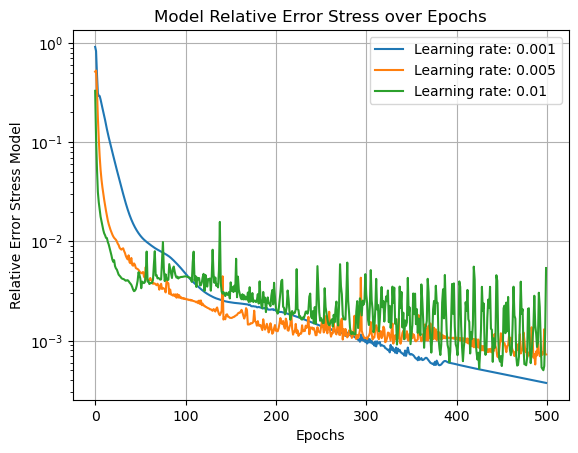

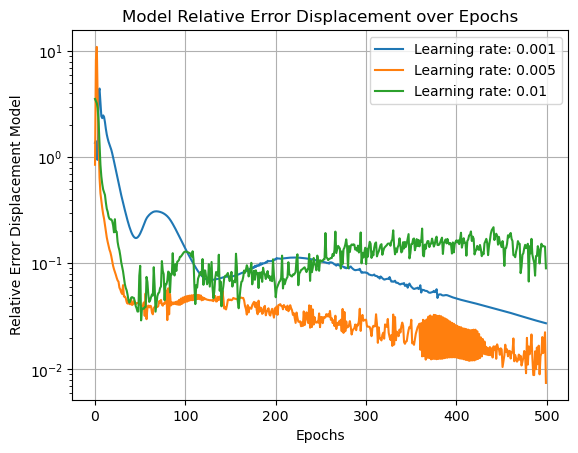

In [15]:
# from PINN.plot import  plot_rel_error_runs
plot_rel_error_runs(rel_errors_sigma_runs, rel_errors_displacement_runs, name_runs, finished_epochs, savepath='modelsPINN/learning_rate')
# print("Relative error sigma: ", rel_errors_sigma_runs[4][-1])
# print("Relative error displacement: ", rel_errors_displacement_runs[4][-1])

In [12]:
def plot_rel_error_runs(rel_errors_sigma_runs, rel_errors_displacement_runs, name_runs, epochs, savepath):
    fig1 = plt.figure('Stress Model Relative Error')
    fig2 = plt.figure('Displacement Model Relative Error')

    # Plot relative errors for the stress model
    for i in range(len(rel_errors_sigma_runs)):
        plt.figure(fig1.number)  # Switch to the stress model figure
        plt.semilogy(range(epochs), rel_errors_sigma_runs[i], label=name_runs[i])
        print("{} {} {}".format(name_runs[i], rel_errors_sigma_runs[i][-1], rel_errors_displacement_runs[i][-1]))

    # Finalize the stress model figure
    plt.figure(fig1.number)
    plt.xlabel('Epochs')
    plt.ylabel('rel_error_stress')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    plt.title('Model Relative Error Stress over Epochs')
    plt.grid(True)
    plt.savefig(f"{savepath}/rel_errors_sigma.png", dpi=300, bbox_inches='tight')

    # Plot relative errors for the displacement model
    for i in range(len(rel_errors_displacement_runs)):
        plt.figure(fig2.number)  # Switch to the displacement model figure
        plt.semilogy(range(epochs), rel_errors_displacement_runs[i], label=name_runs[i])

    # Finalize the displacement model figure
    plt.figure(fig2.number)
    plt.xlabel('Epochs')
    plt.ylabel('rel_error_displacement')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    plt.title('Model Relative Error Displacement over Epochs')
    plt.grid(True)
    plt.savefig(f"{savepath}/rel_errors_displacement.png", dpi=300, bbox_inches='tight')

    # Show both figures at the end
    
    plt.show()

In [36]:
# Set models
from PINN.Dataloader import *

device = 'cuda'
modelSigma = sigmaPINN()
modelSigma =modelSigma.to(device)
modelDisplacement = displacementPINN()
modelDisplacement = modelDisplacement.to(device)

# Apply Xavier initialization to all layers
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)  # Xavier Uniform
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)  # Initialize biases to 0

modelSigma.apply(init_weights)
modelDisplacement.apply(init_weights)

# Set L2 regularization (weight decay)
weight_decay = 1e-4

# Set Adam Optimizer with L2 regularization
optimizerSigma = torch.optim.Adam(modelSigma.parameters(), lr=0.001)
optimizerU = torch.optim.Adam(modelDisplacement.parameters(), lr=0.001)

# Set loss function
loss = PDELoss(lossParam= [1, 1, 1, 1], device=device)

preparedDataSet = datapreparation(dataSet)
dataloader = dataloading(preparedDataSet, 500)

In [37]:
train_losses, inner_train_losses, boundary_train_losses, rel_errors_sigma, rel_errors_displacement, epoch_accuracy, finished_epochs=train_model(modelSigma, modelDisplacement, dataloader, loss, optimizerSigma, optimizerU, epochs=500, device=device)

 Epoch number:  0
 Loss value:  tensor([811.6931], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  1
 Loss value:  tensor([794.4193], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  2
 Loss value:  tensor([789.7020], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  3
 Loss value:  tensor([789.1801], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  4
 Loss value:  tensor([796.8070], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  5
 Loss value:  tensor([803.9974], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  6
 Loss value:  tensor([812.6954], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  7
 Loss value:  tensor([821.1038], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  8
 Loss value:  tensor([815.9951], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  9
 Loss value:  tensor([792.3510], device='cuda:0', grad_fn=<AddBackward0>)
 Epoch number:  10
 Loss value:  tensor([736.6926], device='cuda:0', grad_fn=<Ad

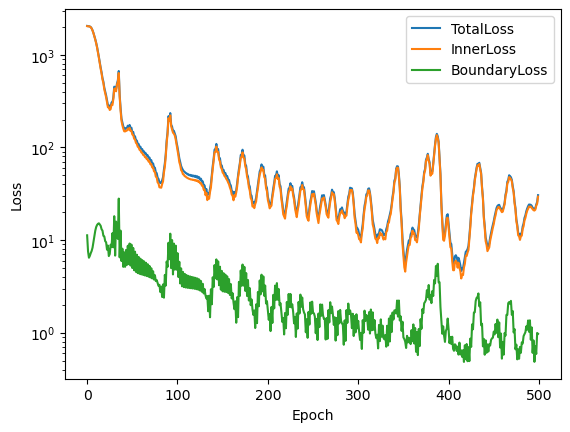

In [38]:
from PINN.plot import plot_loss
plot_loss(train_losses, inner_train_losses, boundary_train_losses, finished_epochs, savepath='modelsPINN/testing')

Relative Error Sigma:  1.8505364656448364 %
Relative Error Displacement:  9.881485998630524 %
Best relative error sigma:  1.2681993655860424 %
Best relative error displacement:  5.941523611545563 %


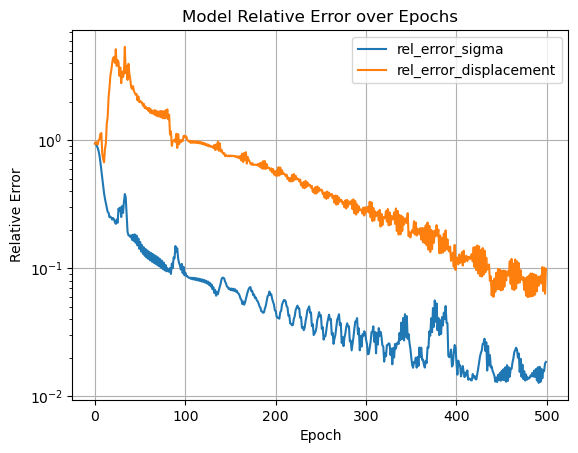

In [39]:
from PINN.plot import plot_rel_error

plot_rel_error(epoch_accuracy, rel_errors_sigma, rel_errors_displacement, savepath='modelsPINN/testing')

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_30500\1200906757.py:44: UserWarning: The following kwargs were not used by contour: 'marker', 's'
  cp = ax11.contourf(xy[0], xy[1], predicted_mesh[:, 0].reshape(size, size),levels=100, alpha = alpha-0.1, cmap='rainbow', marker=marker, s=int(marksize), vmin=-10, vmax=10)


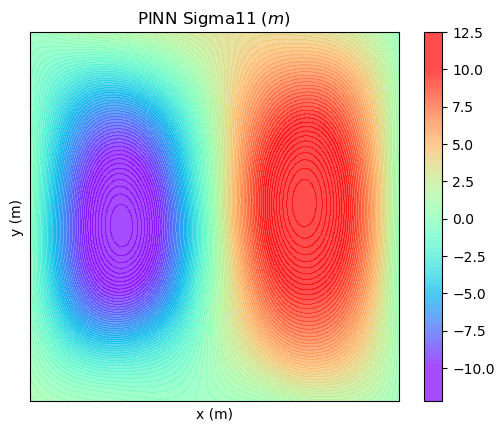

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_30500\1200906757.py:58: UserWarning: The following kwargs were not used by contour: 'edgecolors', 'marker', 's'
  cp = ax12.contourf(xy[0], xy[1], predicted_mesh[:, 1].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-3, vmax=3)


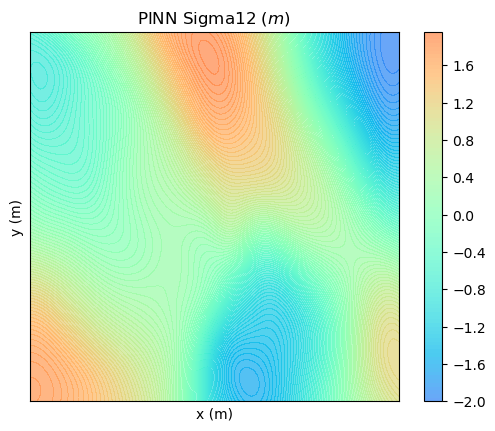

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_30500\1200906757.py:72: UserWarning: The following kwargs were not used by contour: 'edgecolors', 'marker', 's'
  cp = ax21.contourf(xy[0], xy[1], predicted_mesh[:, 2].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-3, vmax=3)


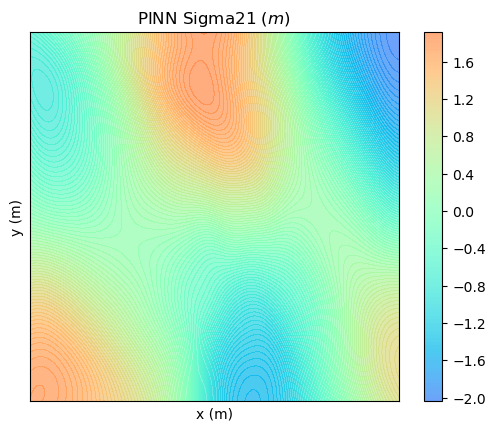

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_30500\1200906757.py:86: UserWarning: The following kwargs were not used by contour: 'edgecolors', 'marker', 's'
  cp = ax22.contourf(xy[0], xy[1], predicted_mesh[:, 3].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-6, vmax=8)


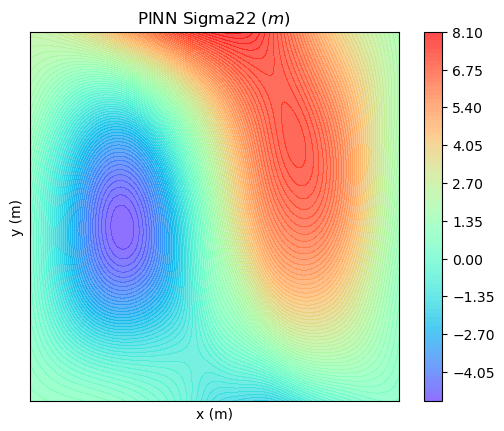

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_30500\1200906757.py:103: UserWarning: The following kwargs were not used by contour: 'edgecolors', 'marker', 's'
  cp = axU.contourf(xy[0], xy[1], predicted_mesh_U[:, 0].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-0.8, vmax=0.8)


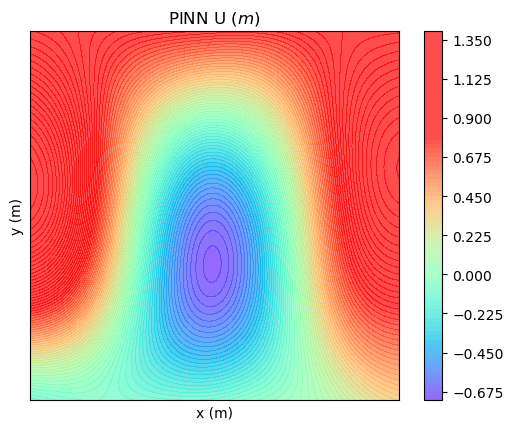

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_30500\1200906757.py:117: UserWarning: The following kwargs were not used by contour: 'edgecolors', 'marker', 's'
  cp = axV.contourf(xy[0], xy[1], predicted_mesh_U[:, 1].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-0.8, vmax=0.8)


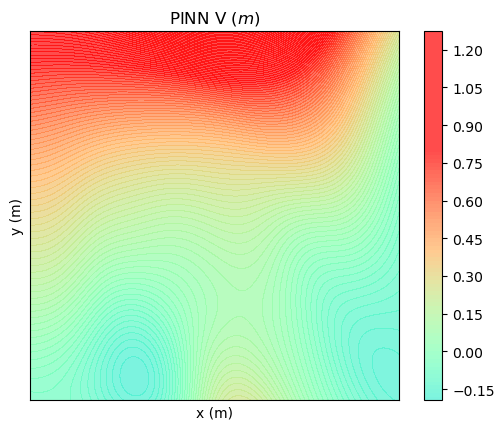

In [10]:
# Plotting the solutions of the NNs

import matplotlib
import matplotlib.pyplot as plt

# sigma = modelSigma (innerPoints)

# innerPointsNumpy = innerPoints.detach().numpy()
# sigma = sigma.detach().numpy()

import numpy as np

xmin = 0
xmax = 1
ymin = 0
ymax = 1

size=200
x = np.linspace(xmin, xmax, size)
y = np.linspace(ymin, ymax, size)
xy = np.meshgrid(x, y)
x_mesh = xy[0].reshape(-1, 1)
y_mesh = xy[1].reshape(-1, 1)
xy_mesh = np.concatenate((x_mesh, y_mesh), axis=1)

xy_mesh = torch.tensor(xy_mesh, dtype=torch.float32).to(device=device)
predicted_mesh = modelSigma(xy_mesh).to(device='cpu')
predicted_mesh = predicted_mesh.detach().numpy()

predicted_mesh_U = modelDisplacement(xy_mesh).to(device='cpu')
predicted_mesh_U = predicted_mesh_U.detach().numpy()

normuv = matplotlib.colors.Normalize(vmin=-0.8, vmax=0.8)
normsigma = matplotlib.colors.Normalize(vmin=-10, vmax=10)

marksize=2
alpha=0.8
marker='o'
savepath = './PINN/solutions'


fig11, ax11 = plt.subplots()
ax11.set_aspect('equal')
cp = ax11.contourf(xy[0], xy[1], predicted_mesh[:, 0].reshape(size, size),levels=100, alpha = alpha-0.1, cmap='rainbow', marker=marker, s=int(marksize), vmin=-10, vmax=10)
ax11.set_xticks([])
ax11.set_yticks([])
ax11.set_xlim([xmin, xmax])
ax11.set_ylim([ymin, ymax])
ax11.set_xlabel("x (m)")
ax11.set_ylabel("y (m)")
plt.title('PINN Sigma11 $(m)$')
fig11.colorbar(cp)
plt.savefig(savepath + '/sxx_PINN.png', dpi=300)
plt.show()

fig12, ax12 = plt.subplots()
ax12.set_aspect('equal')
cp = ax12.contourf(xy[0], xy[1], predicted_mesh[:, 1].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-3, vmax=3)
ax12.set_xticks([])
ax12.set_yticks([])
ax12.set_xlim([xmin, xmax])
ax12.set_ylim([ymin, ymax])
ax12.set_xlabel("x (m)")
ax12.set_ylabel("y (m)")
plt.title('PINN Sigma12 $(m)$')
fig12.colorbar(cp)
plt.savefig(savepath + '/sxy_PINN.png', dpi=300)
plt.show()

fig21, ax21 = plt.subplots()
ax21.set_aspect('equal')
cp = ax21.contourf(xy[0], xy[1], predicted_mesh[:, 2].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-3, vmax=3)
ax21.set_xticks([])
ax21.set_yticks([])
ax21.set_xlim([xmin, xmax])
ax21.set_ylim([ymin, ymax])
ax21.set_xlabel("x (m)")
ax21.set_ylabel("y (m)")
plt.title('PINN Sigma21 $(m)$')
fig21.colorbar(cp)
plt.savefig(savepath + '/syx_PINN.png', dpi=300)
plt.show()

fig22, ax22 = plt.subplots()
ax22.set_aspect('equal')
cp = ax22.contourf(xy[0], xy[1], predicted_mesh[:, 3].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-6, vmax=8)
ax22.set_xticks([])
ax22.set_yticks([])
ax22.set_xlim([xmin, xmax])
ax22.set_ylim([ymin, ymax])
ax22.set_xlabel("x (m)")
ax22.set_ylabel("y (m)")
plt.title('PINN Sigma22 $(m)$')
fig22.colorbar(cp)
plt.savefig(savepath + '/syy_PINN.png', dpi=300)
plt.show()

u = modelDisplacement(xy_mesh).to(device='cpu')
u = u.detach().numpy()

figU, axU = plt.subplots()
axU.set_aspect('equal')
cp = axU.contourf(xy[0], xy[1], predicted_mesh_U[:, 0].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-0.8, vmax=0.8)
axU.set_xticks([])
axU.set_yticks([])
axU.set_xlim([xmin, xmax])
axU.set_ylim([ymin, ymax])
axU.set_xlabel("x (m)")
axU.set_ylabel("y (m)")
plt.title('PINN U $(m)$')
figU.colorbar(cp)
plt.savefig(savepath + '/u_PINN.png', dpi=300)
plt.show()

figV, axV = plt.subplots()
axV.set_aspect('equal')
cp = axV.contourf(xy[0], xy[1], predicted_mesh_U[:, 1].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-0.8, vmax=0.8)
axV.set_xticks([])
axV.set_yticks([])
axV.set_xlim([xmin, xmax])
axV.set_ylim([ymin, ymax])
axV.set_xlabel("x (m)")
axV.set_ylabel("y (m)")
plt.title('PINN V $(m)$')
figV.colorbar(cp)
plt.savefig(savepath + '/v_PINN.png', dpi=300)
plt.show()

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_12556\2631241721.py:40: UserWarning: The following kwargs were not used by contour: 'edgecolors', 'marker', 's'
  cp = ax11.contourf(xy[0], xy[1], predicted_mesh[:, 0].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-10, vmax=10)


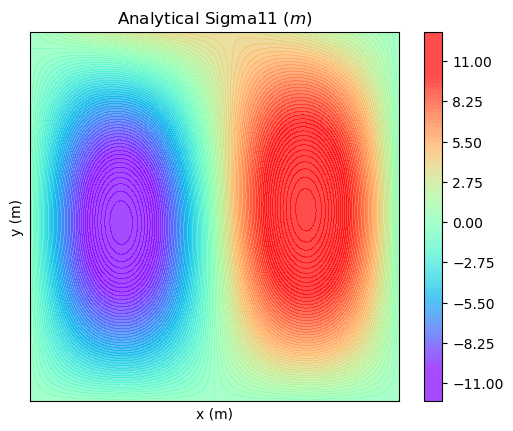

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_12556\2631241721.py:54: UserWarning: The following kwargs were not used by contour: 'edgecolors', 'marker', 's'
  cp = ax12.contourf(xy[0], xy[1], predicted_mesh[:, 1].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-3, vmax=3)


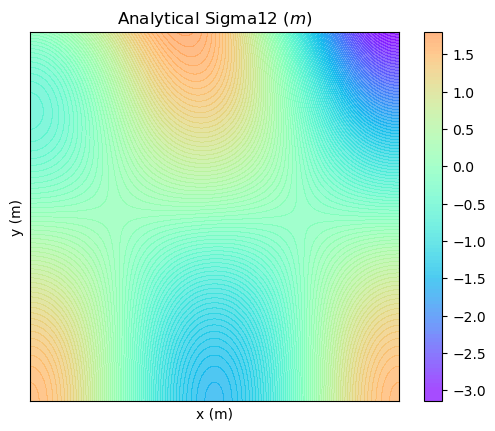

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_12556\2631241721.py:68: UserWarning: The following kwargs were not used by contour: 'edgecolors', 'marker', 's'
  cp = ax21.contourf(xy[0], xy[1], predicted_mesh[:, 2].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-3, vmax=3)


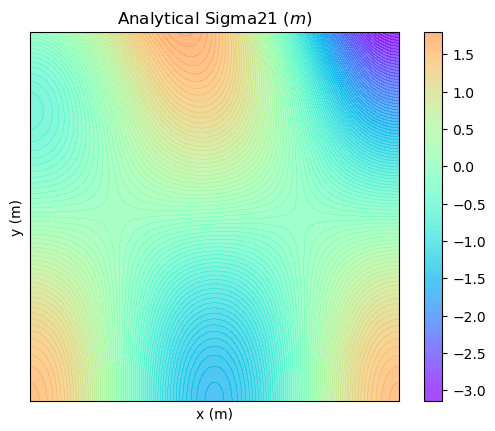

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_12556\2631241721.py:82: UserWarning: The following kwargs were not used by contour: 'edgecolors', 'marker', 's'
  cp = ax22.contourf(xy[0], xy[1], predicted_mesh[:, 3].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-6, vmax=8)


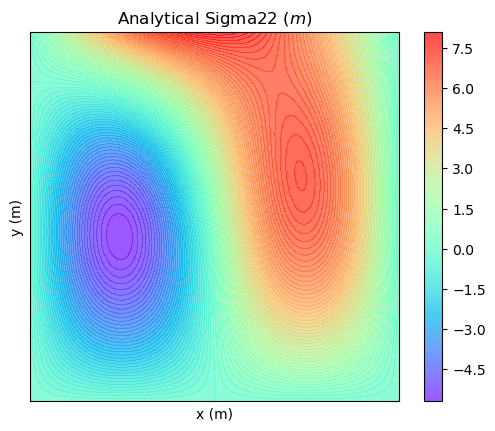

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_12556\2631241721.py:97: UserWarning: The following kwargs were not used by contour: 'edgecolors', 'marker', 's'
  cp = axU.contourf(xy[0], xy[1], predicted_mesh_U[:, 0].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-0.8, vmax=0.8)


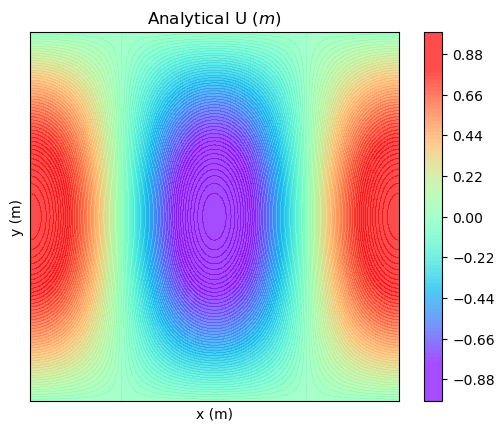

C:\Users\Radu Vasilache\AppData\Local\Temp\ipykernel_12556\2631241721.py:111: UserWarning: The following kwargs were not used by contour: 'edgecolors', 'marker', 's'
  cp = axV.contourf(xy[0], xy[1], predicted_mesh_U[:, 1].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-0.8, vmax=0.8)


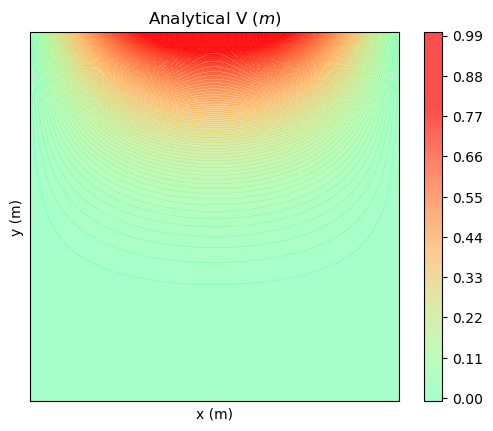

In [12]:
# Plotting the analytical solution

import matplotlib
import matplotlib.pyplot as plt
import torch
from PINN.analSolution import *

import numpy as np

xmin = 0
xmax = 1
ymin = 0
ymax = 1

size = 200
x = np.linspace(xmin, xmax, size)
y = np.linspace(ymin, ymax, size)
xy = np.meshgrid(x, y)
x_mesh = xy[0].reshape(-1, 1)
y_mesh = xy[1].reshape(-1, 1)
xy_mesh = np.concatenate((x_mesh, y_mesh), axis=1)

xy_mesh = torch.tensor(xy_mesh, dtype=torch.float32).to(device='cpu')
predicted_mesh = getSigmaAnal(xy_mesh).to(device='cpu')
predicted_mesh = predicted_mesh.detach().numpy()

predicted_mesh_U = getDisplacementAnal(xy_mesh).to(device='cpu')
predicted_mesh_U = predicted_mesh_U.detach().numpy()

normuv = matplotlib.colors.Normalize(vmin=-0.8, vmax=0.8)
normsigma = matplotlib.colors.Normalize(vmin=-10, vmax=10)

marksize=2
alpha=0.8
marker='o'
savepath = './PINN/solutions_anal'

fig11, ax11 = plt.subplots() 
ax11.set_aspect('equal')
cp = ax11.contourf(xy[0], xy[1], predicted_mesh[:, 0].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-10, vmax=10)
ax11.set_xticks([])
ax11.set_yticks([])
ax11.set_xlim([xmin, xmax])
ax11.set_ylim([ymin, ymax])
ax11.set_xlabel("x (m)")
ax11.set_ylabel("y (m)")
plt.title('Analytical Sigma11 $(m)$')
fig11.colorbar(cp)
plt.savefig(savepath + '/sxx_Anal.png', dpi=300)
plt.show()

fig12, ax12 = plt.subplots()
ax12.set_aspect('equal')
cp = ax12.contourf(xy[0], xy[1], predicted_mesh[:, 1].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-3, vmax=3)
ax12.set_xticks([])
ax12.set_yticks([])
ax12.set_xlim([xmin, xmax])
ax12.set_ylim([ymin, ymax])
ax12.set_xlabel("x (m)")
ax12.set_ylabel("y (m)")
plt.title('Analytical Sigma12 $(m)$')
fig12.colorbar(cp)
plt.savefig(savepath + '/sxy_Anal.png', dpi=300)
plt.show()

fig21, ax21 = plt.subplots()
ax21.set_aspect('equal')
cp = ax21.contourf(xy[0], xy[1], predicted_mesh[:, 2].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-3, vmax=3)
ax21.set_xticks([])
ax21.set_yticks([])
ax21.set_xlim([xmin, xmax])
ax21.set_ylim([ymin, ymax])
ax21.set_xlabel("x (m)")
ax21.set_ylabel("y (m)")
plt.title('Analytical Sigma21 $(m)$')
fig21.colorbar(cp)
plt.savefig(savepath + '/syx_Anal.png', dpi=300)
plt.show()

fig22, ax22 = plt.subplots()
ax22.set_aspect('equal')
cp = ax22.contourf(xy[0], xy[1], predicted_mesh[:, 3].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-6, vmax=8)
ax22.set_xticks([])
ax22.set_yticks([])
ax22.set_xlim([xmin, xmax])
ax22.set_ylim([ymin, ymax])
ax22.set_xlabel("x (m)")
ax22.set_ylabel("y (m)")
plt.title('Analytical Sigma22 $(m)$')
fig22.colorbar(cp)
plt.savefig(savepath + '/syy_Anal.png', dpi=300)
plt.show()


figU, axU = plt.subplots()
axU.set_aspect('equal')
cp = axU.contourf(xy[0], xy[1], predicted_mesh_U[:, 0].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-0.8, vmax=0.8)
axU.set_xticks([])
axU.set_yticks([])
axU.set_xlim([xmin, xmax])
axU.set_ylim([ymin, ymax])
axU.set_xlabel("x (m)")
axU.set_ylabel("y (m)")
plt.title('Analytical U $(m)$')
figU.colorbar(cp)
plt.savefig(savepath + '/u_Anal.png', dpi=300)
plt.show()

figV, axV = plt.subplots()
axV.set_aspect('equal')
cp = axV.contourf(xy[0], xy[1], predicted_mesh_U[:, 1].reshape(size, size), levels=100, alpha = alpha-0.1, edgecolors='None', cmap='rainbow', marker=marker, s=int(marksize), vmin=-0.8, vmax=0.8)
axV.set_xticks([])
axV.set_yticks([])
axV.set_xlim([xmin, xmax])
axV.set_ylim([ymin, ymax])
axV.set_xlabel("x (m)")
axV.set_ylabel("y (m)")
plt.title('Analytical V $(m)$')
figV.colorbar(cp)
plt.savefig(savepath + '/v_Anal.png', dpi=300)
plt.show()